In [12]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
from keras import Model
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Basic cleaning using utility function  
* Use only int features
* Use 60% BOD as cutoff for ground true labeling
* Clean unique input columns

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
feat_int = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='int')


In [4]:
feat_int.shape

(1063, 61)

* Clean unique input columns calling from utility function

In [3]:
selected_feat_int=utilities.dedup_input_cols(feat_int)

In [4]:
selected_feat_int.shape # only 59 features

(1063, 59)

In [7]:
selected_feat_int.describe()

,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumRings,NumHeteroatoms,NumAmideBonds,NumAromaticRings,NumHBA,NumAliphaticRings,NumSaturatedRings,...,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN40,MQN41,MQN42
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2.462841,0.913452,3.785513,1.050800,3.348071,0.099718,0.809031,2.209784,0.241769,0.156162,...,0.060207,0.031985,0.003763,0.119473,0.884290,0.001881,0.003763,0.005644,0.392286,0.226717
std,2.087602,1.234332,5.866459,1.089782,2.882053,0.431166,0.932886,1.904059,0.644304,0.498658,...,0.400267,0.239492,0.061256,0.442373,0.941194,0.043355,0.061256,0.086609,1.372111,0.908405
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,2.000000,1.000000,3.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,1.000000,4.000000,2.000000,4.000000,0.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.000000,8.000000,64.000000,10.000000,29.000000,4.000000,6.000000,13.000000,5.000000,4.000000,...,6.000000,4.000000,1.000000,4.000000,6.000000,1.000000,1.000000,2.000000,21.000000,14.000000


### label BOD with desired partition

(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

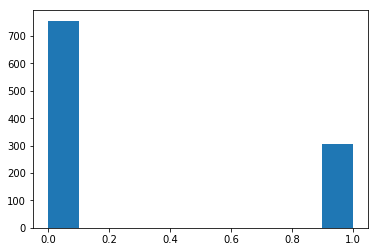

In [5]:
df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

### Build baseline cluster model

In [9]:
from cluster import KMeans

In [10]:
kmeans_cluster = KMeans(n_clusters=2)

* Without normalization

In [11]:
kmeans_cluster.build_model()
results = kmeans_cluster.train_model(selected_feat_int.values, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.5622474384371878
calinski score: 662.2716815439967

Metric with True label
adjusted rand score: 0.008250689774362363 
fowlkes_mallows : 0.6759758704544127


(array([922.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 141.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

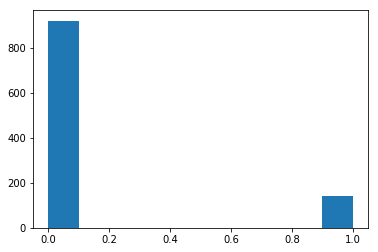

In [12]:
plt.hist(results[0])

* With normalization

In [58]:
from keras.utils import normalize
selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=100)

** Example of keras normalize

In [59]:
data = np.array([
    [1000, 10, 0.5],
    [765, 5, 0.35],
    [800, 7, 0.09], ])

In [62]:
normalize(data, axis=0, order=100) # order >80 to represent min-max normalization

array([[1.   , 1.   , 1.   ],
       [0.765, 0.5  , 0.7  ],
       [0.8  , 0.7  , 0.18 ]])

In [61]:
pd.DataFrame(selected_feat_int_norm).describe()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,0.164188,0.114182,0.059149,0.105080,0.115417,0.024586,0.134839,0.169981,0.047825,0.038614,...,0.009965,0.007996,0.003711,0.029391,0.147382,0.001868,0.003711,0.002822,0.018680,0.016194
std,0.139172,0.154292,0.091663,0.108978,0.099352,0.106307,0.155481,0.146464,0.127453,0.123303,...,0.066250,0.059873,0.060413,0.108828,0.156866,0.043056,0.060413,0.043304,0.065339,0.064886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.066666,0.000000,0.015625,0.000000,0.068945,0.000000,0.000000,0.076922,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.133332,0.000000,0.031250,0.100000,0.103418,0.000000,0.166667,0.153844,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.266664,0.125000,0.062500,0.200000,0.137890,0.000000,0.166667,0.230765,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.999990,1.000000,1.000000,1.000000,0.999705,0.986233,1.000000,0.999983,0.989074,0.989074,...,0.993092,1.000000,0.986233,0.984034,1.000000,0.993092,0.986233,1.000000,1.000000,1.000000


In [75]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.build_model()
temp_outcome=kmeans_cluster.train_model(selected_feat_int_norm, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.23900635324388148
calinski score: 166.13134304252884

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028


In [78]:
temp_outcome[1]['adjusted_rand_score']

-0.0284578216480051

#### Test how normalization order affect the results

In [90]:
ad_rand_score = []
silhouettes= []
for i in range(-2,80):
    selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=i)
    kmeans_cluster = KMeans(n_clusters=2)
    kmeans_cluster.build_model()
    temp_outcome = kmeans_cluster.train_model(selected_feat_int_norm, true_labels=true_label_biclass)
    ad_rand_score.append(temp_outcome[1]['adjusted_rand_score'])
    silhouettes.append(temp_outcome[1]['silhouette_score'])

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in power
  absx **= ord


Metrics without ture labels
silhouette score: 0.6285788790114298
calinski score: 1295.8554805705685

Metric with True label
adjusted rand score: -0.01823499535728975 
fowlkes_mallows : 0.64336148456634


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in reciprocal
  absx **= ord


Metrics without ture labels
silhouette score: 0.6563290323083916
calinski score: 1432.3552598931533

Metric with True label
adjusted rand score: -0.021189539063848843 
fowlkes_mallows : 0.6457692240635479
Metrics without ture labels
silhouette score: 0.938609456318244
calinski score: 1658.273644097982

Metric with True label
adjusted rand score: -0.00868493415254232 
fowlkes_mallows : 0.7592277000556553
Metrics without ture labels
silhouette score: 0.9357032559581484
calinski score: 244.2118038721719

Metric with True label
adjusted rand score: 0.0016215088477707466 
fowlkes_mallows : 0.7663380586804177
Metrics without ture labels
silhouette score: 0.42662489205378124
calinski score: 116.59213501508897

Metric with True label
adjusted rand score: -0.0072175321765158736 
fowlkes_mallows : 0.6863043742455759
Metrics without ture labels
silhouette score: 0.2699592983605325
calinski score: 120.7037839652916

Metric with True label
adjusted rand score: -0.05138019448648896 
fowlkes_mallows 

calinski score: 166.18721457100014

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028


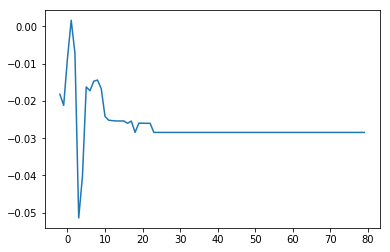

In [91]:
plt.plot(list(range(-2,80)), ad_rand_score)

(-2, 10)

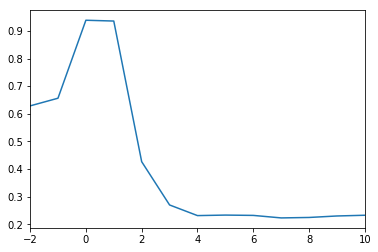

In [97]:
plt.plot(list(range(-2,80)), silhouettes)
plt.xlim(-2, 10)

In [98]:
pd.DataFrame(normalize(selected_feat_int.values, axis=0, order=1)).describe()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,...,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941
std,0.000797,0.001271,0.001458,0.000976,0.000810,0.004068,0.001085,0.000811,0.002507,0.003004,...,0.006254,0.007044,0.015314,0.003483,0.001001,0.021678,0.015314,0.014435,0.003290,0.003769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000382,0.000000,0.000249,0.000000,0.000562,0.000000,0.000000,0.000426,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000764,0.000000,0.000497,0.000895,0.000843,0.000000,0.001163,0.000851,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001064,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.001528,0.001030,0.000994,0.001791,0.001124,0.000000,0.001163,0.001277,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001064,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.005730,0.008239,0.015905,0.008953,0.008148,0.037736,0.006977,0.005534,0.019455,0.024096,...,0.093750,0.117647,0.250000,0.031496,0.006383,0.500000,0.250000,0.333333,0.050360,0.058091


In [123]:
selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=0) #select order=0 for the best silhuette score

In [124]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.build_model()
temp_outcome = kmeans_cluster.train_model(selected_feat_int_norm, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.938609456318244
calinski score: 1658.273644097982

Metric with True label
adjusted rand score: -0.00868493415254232 
fowlkes_mallows : 0.7592277000556553


### dce model

In [13]:
autoencoder_dims = [59,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
dce.build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
dce.model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 59)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 59)           236         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 45)           2700        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           920         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

In [131]:
[y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)

Instructions for updating:
Use tf.cast instead.
Epoch: 0
  Total_loss = 0.008127097;Delta_label = 0.0
  Clustering_loss = 0.00016264408; Decoder_loss = 0.01609155
Epoch: 25
  Total_loss = 0.00052470725;Delta_label = 0.1702728127939793
  Clustering_loss = 8.771115e-06; Decoder_loss = 0.0010406434
Epoch: 50
  Total_loss = 0.0004430084;Delta_label = 0.05644402634054563
  Clustering_loss = 1.9301662e-05; Decoder_loss = 0.00086671516
Epoch: 75
  Total_loss = 0.00044250663;Delta_label = 0.07902163687676388
  Clustering_loss = 6.8799476e-05; Decoder_loss = 0.0008162138
Epoch: 100
  Total_loss = 0.0005167383;Delta_label = 0.08936970837253057
  Clustering_loss = 0.0002644112; Decoder_loss = 0.0007690654
Epoch: 125
  Total_loss = 0.00087196846;Delta_label = 0.045155221072436504
  Clustering_loss = 0.0010051723; Decoder_loss = 0.0007387647
Epoch: 150
  Total_loss = 0.0020470787;Delta_label = 0.04985888993414864
  Clustering_loss = 0.0033730257; Decoder_loss = 0.0007211317
Epoch: 175
  Total_loss 

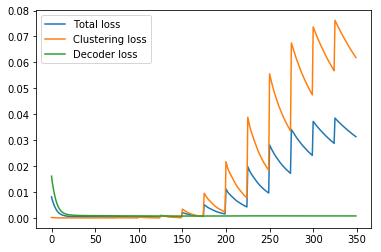

In [132]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

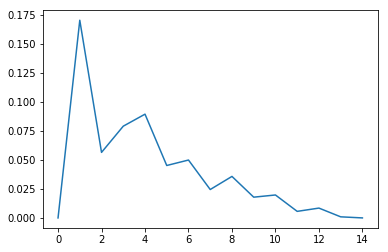

In [133]:
plt.plot(delta_label)


(array([508.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 555.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

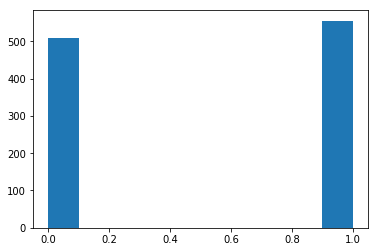

In [134]:
plt.hist(y_pred)


In [135]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)


Metric with True label
adjusted rand score: 0.000834963595056379 
fowlkes_mallows : 0.543255217409827


{'adjusted_rand_score': 0.000834963595056379,
 'fowlkes_mallows_score': 0.543255217409827}

In [137]:
Cluster.no_label_metrics(selected_feat_int, y_pred, print_metric=True)

Metrics without ture labels
silhouette score: 0.03614558607890322
calinski score: 16.894826568392805


{'silhouette_score': 0.03614558607890322, 'calinski_score': 16.894826568392805}

### Same parameter for normalized data order = 0

Epoch: 0
  Total_loss = 0.015591982;Delta_label = 0.0
  Clustering_loss = 0.0002740092; Decoder_loss = 0.030909954
Epoch: 25
  Total_loss = 0.00067973236;Delta_label = 0.18626528692380057
  Clustering_loss = 1.3102276e-05; Decoder_loss = 0.0013463624
Epoch: 50
  Total_loss = 0.00048587812;Delta_label = 0.06867356538099718
  Clustering_loss = 3.1297255e-05; Decoder_loss = 0.00094045897
Epoch: 75
  Total_loss = 0.00048633548;Delta_label = 0.05832549388523048
  Clustering_loss = 0.00010477651; Decoder_loss = 0.00086789444
Epoch: 100
  Total_loss = 0.0006169959;Delta_label = 0.03198494825964252
  Clustering_loss = 0.000403241; Decoder_loss = 0.0008307508
Epoch: 125
  Total_loss = 0.0012190619;Delta_label = 0.04045155221072436
  Clustering_loss = 0.0016283952; Decoder_loss = 0.0008097285
Epoch: 150
  Total_loss = 0.0032321867;Delta_label = 0.03386641580432737
  Clustering_loss = 0.0056500346; Decoder_loss = 0.00081433845
Epoch: 175
  Total_loss = 0.008331884;Delta_label = 0.0357478833490122

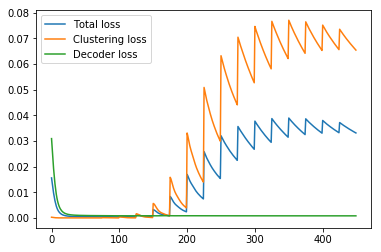

In [139]:
autoencoder_dims = [59,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
dce.build_model()
[y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()




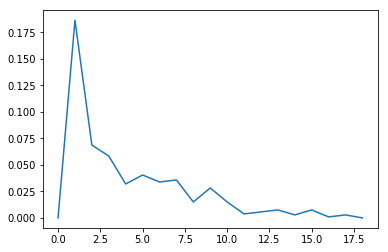

In [143]:
plt.plot(delta_label)


(array([504.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 559.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

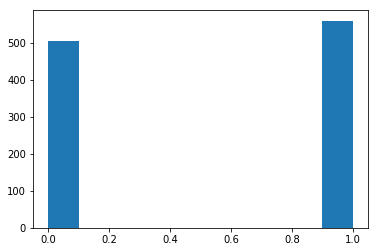

In [144]:
plt.hist(y_pred)

In [142]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)
Cluster.no_label_metrics(selected_feat_int_norm, y_pred, print_metric=True)

Metric with True label
adjusted rand score: 0.01538022852295646 
fowlkes_mallows : 0.550144819683573
Metrics without ture labels
silhouette score: 0.07287341846189183
calinski score: 10.104416975180637


{'silhouette_score': 0.07287341846189183, 'calinski_score': 10.104416975180637}

In [147]:
Cluster.true_label_metrics(true_label_biclass, y_pred, print_metric=True)['adjusted_rand_score']

Metric with True label
adjusted rand score: 0.01538022852295646 
fowlkes_mallows : 0.550144819683573


0.01538022852295646

Better adjusted rand score for normalized data

In [154]:
adjusted_rands = []
for i in range(-2,10):
    selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=i)
    dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
    dce.build_model()
    [y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)
    adjusted_rands.append(Cluster.true_label_metrics(true_label_biclass, y_pred, print_metric=True)['adjusted_rand_score'])

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in power
  absx **= ord


Epoch: 0
  Total_loss = 0.010350223;Delta_label = 0.0
  Clustering_loss = 0.0001903286; Decoder_loss = 0.020510117
Epoch: 50
  Total_loss = 0.0004521008;Delta_label = 0.19943555973659455
  Clustering_loss = 7.6084384e-06; Decoder_loss = 0.00089659315
Epoch: 100
  Total_loss = 0.00040876836;Delta_label = 0.06114769520225776
  Clustering_loss = 2.7611124e-05; Decoder_loss = 0.00078992563
Epoch: 150
  Total_loss = 0.00040839973;Delta_label = 0.030103480714957668
  Clustering_loss = 0.00010589828; Decoder_loss = 0.00071090116
Epoch: 200
  Total_loss = 0.0005318459;Delta_label = 0.01975540921919097
  Clustering_loss = 0.00041028942; Decoder_loss = 0.00065340236
Epoch: 250
  Total_loss = 0.001068021;Delta_label = 0.01317027281279398
  Clustering_loss = 0.001524397; Decoder_loss = 0.0006116451
Epoch: 300
  Total_loss = 0.002931247;Delta_label = 0.01881467544684854
  Clustering_loss = 0.0052729556; Decoder_loss = 0.00058953837
Epoch: 350
  Total_loss = 0.008000045;Delta_label = 0.0225776105362

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in reciprocal
  absx **= ord


Epoch: 0
  Total_loss = 0.013650178;Delta_label = 0.0
  Clustering_loss = 0.0005747296; Decoder_loss = 0.026725626
Epoch: 50
  Total_loss = 0.00048379775;Delta_label = 0.17403574788334902
  Clustering_loss = 2.3315366e-05; Decoder_loss = 0.0009442801
Epoch: 100
  Total_loss = 0.0004438042;Delta_label = 0.06114769520225776
  Clustering_loss = 7.5527656e-05; Decoder_loss = 0.00081208075
Epoch: 150
  Total_loss = 0.0005158157;Delta_label = 0.04609595484477893
  Clustering_loss = 0.00027481338; Decoder_loss = 0.000756818
Epoch: 200
  Total_loss = 0.00088065193;Delta_label = 0.02539981185324553
  Clustering_loss = 0.0010434618; Decoder_loss = 0.000717842
Epoch: 250
  Total_loss = 0.0022375896;Delta_label = 0.015051740357478834
  Clustering_loss = 0.0037976652; Decoder_loss = 0.000677514
Epoch: 300
  Total_loss = 0.00632778;Delta_label = 0.01599247412982126
  Clustering_loss = 0.011990333; Decoder_loss = 0.0006652272
Epoch: 350
  Total_loss = 0.014648219;Delta_label = 0.02916274694261524
  C

Epoch: 700
  Total_loss = 0.027603528;Delta_label = 0.004703668861712135
  Clustering_loss = 0.05448664; Decoder_loss = 0.0007204166
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Metric with True label
adjusted rand score: 0.006909113135717661 
fowlkes_mallows : 0.5475843800878833
Epoch: 0
  Total_loss = 0.0099207265;Delta_label = 0.0
  Clustering_loss = 0.0011975965; Decoder_loss = 0.018643856
Epoch: 50
  Total_loss = 0.0004707953;Delta_label = 0.1251175917215428
  Clustering_loss = 1.646769e-05; Decoder_loss = 0.0009251229
Epoch: 100
  Total_loss = 0.00042180243;Delta_label = 0.07243650047036689
  Clustering_loss = 4.53406e-05; Decoder_loss = 0.0007982642
Epoch: 150
  Total_loss = 0.00044085132;Delta_label = 0.08936970837253057
  Clustering_loss = 0.0001590382; Decoder_loss = 0.00072266447
Epoch: 200
  Total_loss = 0.00063189596;Delta_label = 0.047036688617121354
  Clustering_loss = 0.00059128116; Decoder_loss = 0.0006725108
Epoch: 250
  Total_loss = 0.0014179454;Delta

In [ ]:
### The adjusted rand score vs. normalization order is not reproducible over the training

### parameter tuning for non-normalized int feature

In [20]:
ad_rands=[]
for i in np.arange(0,1.1,0.1):
    autoencoder_dims = [59,30,20]
    dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
    dce.build_model()
    [y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=i)
    ad_rands.append((i,Cluster.true_label_metrics(true_label_biclass, y_pred, print_metric=True)['adjusted_rand_score']))

Epoch: 0
  Total_loss = 0.010768806;Delta_label = 0.0
  Clustering_loss = 0.0010574805; Decoder_loss = 0.010768806
Epoch: 25
  Total_loss = 0.0011815239;Delta_label = 0.9247412982126059
  Clustering_loss = 3.852523e-05; Decoder_loss = 0.0011815239
Epoch: 50
  Total_loss = 0.00088949554;Delta_label = 0.0009407337723424271
  Clustering_loss = 4.143026e-05; Decoder_loss = 0.00088949554
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Metric with True label
adjusted rand score: -0.0011165248915842615 
fowlkes_mallows : 0.7663239502889049
Epoch: 0
  Total_loss = 0.013065376;Delta_label = 0.0
  Clustering_loss = 0.00043829472; Decoder_loss = 0.014468385
Epoch: 25
  Total_loss = 0.0010849261;Delta_label = 0.26528692380056446
  Clustering_loss = 3.28365e-05; Decoder_loss = 0.001201825
Epoch: 50
  Total_loss = 0.00079687656;Delta_label = 0.05644402634054563
  Clustering_loss = 4.9313774e-05; Decoder_loss = 0.0008799391
Epoch: 75
  Total_loss = 0.00073840347;Delta_label = 0.098777046

  Total_loss = 0.029681819;Delta_label = 0.024459078080903106
  Clustering_loss = 0.042044036; Decoder_loss = 0.00083664263
Epoch: 250
  Total_loss = 0.040340744;Delta_label = 0.011288805268109126
  Clustering_loss = 0.057272177; Decoder_loss = 0.00083407306
Epoch: 275
  Total_loss = 0.04775071;Delta_label = 0.008466603951081843
  Clustering_loss = 0.06786693; Decoder_loss = 0.00081286865
Epoch: 300
  Total_loss = 0.051128387;Delta_label = 0.004703668861712135
  Clustering_loss = 0.07269305; Decoder_loss = 0.000810843
Epoch: 325
  Total_loss = 0.05219237;Delta_label = 0.0028222013170272815
  Clustering_loss = 0.074216485; Decoder_loss = 0.0008027767
Epoch: 350
  Total_loss = 0.051989555;Delta_label = 0.0028222013170272815
  Clustering_loss = 0.07392986; Decoder_loss = 0.0007955104
Epoch: 375
  Total_loss = 0.051191945;Delta_label = 0.0028222013170272815
  Clustering_loss = 0.072796255; Decoder_loss = 0.00078188535
Epoch: 400
  Total_loss = 0.050129496;Delta_label = 0.001881467544684854

In [21]:
x, y = zip(*ad_rands)

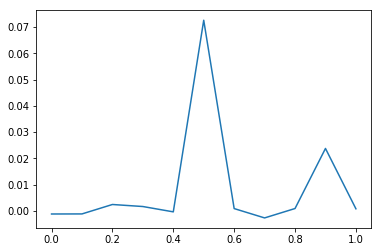

In [22]:
plt.plot(x,y)

### Visualization Using True label

In [6]:
from dimreducer import DeepAutoEncoder as DAE

In [14]:
dims =[59,40,20]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history1 = autoencoder.train_model(selected_feat_int, norm_feature=False, epochs=100)

Epoch 1/100
1063/1063 [==============================] - ETA: 1s - loss: 13.34 - 1s 502us/step - loss: 13.5159
Epoch 2/100
1063/1063 [==============================] - ETA: 0s - loss: 13.34 - 0s 14us/step - loss: 12.7039
Epoch 3/100
1063/1063 [==============================] - ETA: 0s - loss: 9.442 - 0s 21us/step - loss: 11.6426
Epoch 4/100
1063/1063 [==============================] - ETA: 0s - loss: 8.564 - 0s 16us/step - loss: 10.4033
Epoch 5/100
1063/1063 [==============================] - ETA: 0s - loss: 9.655 - 0s 25us/step - loss: 8.9831
Epoch 6/100
1063/1063 [==============================] - ETA: 0s - loss: 7.310 - 0s 15us/step - loss: 7.4718
Epoch 7/100
1063/1063 [==============================] - ETA: 0s - loss: 5.733 - 0s 15us/step - loss: 6.1052
Epoch 8/100
1063/1063 [==============================] - ETA: 0s - loss: 5.275 - 0s 19us/step - loss: 5.0221
Epoch 9/100
1063/1063 [==============================] - ETA: 0s - loss: 5.501 - 0s 16us/step - loss: 4.2486
Epoch 10/100
1

1063/1063 [==============================] - ETA: 0s - loss: 1.337 - 0s 17us/step - loss: 1.2054
Epoch 76/100
1063/1063 [==============================] - ETA: 0s - loss: 1.415 - 0s 17us/step - loss: 1.2020
Epoch 77/100
1063/1063 [==============================] - ETA: 0s - loss: 1.444 - 0s 17us/step - loss: 1.1995
Epoch 78/100
1063/1063 [==============================] - ETA: 0s - loss: 1.337 - 0s 20us/step - loss: 1.1971
Epoch 79/100
1063/1063 [==============================] - ETA: 0s - loss: 1.177 - 0s 19us/step - loss: 1.1954
Epoch 80/100
1063/1063 [==============================] - ETA: 0s - loss: 1.168 - 0s 17us/step - loss: 1.1940
Epoch 81/100
1063/1063 [==============================] - ETA: 0s - loss: 1.359 - 0s 14us/step - loss: 1.1916
Epoch 82/100
1063/1063 [==============================] - ETA: 0s - loss: 1.301 - 0s 14us/step - loss: 1.1890
Epoch 83/100
1063/1063 [==============================] - ETA: 0s - loss: 1.232 - 0s 29us/step - loss: 1.1877
Epoch 84/100
1063/1063 

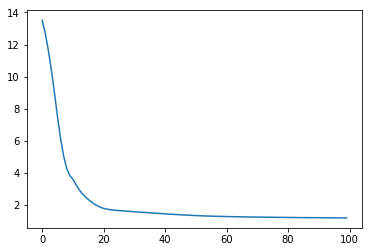

In [15]:
plt.plot(history1.history['loss'])

Text(0.5, 1.0, 'Use encoded int feature')

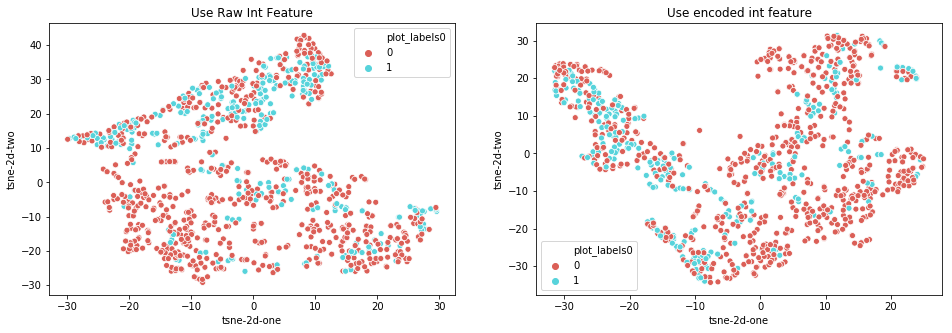

In [13]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(selected_feat_int)
fig, ax=plt.subplots(1,2,figsize=(16,5))
utilities.tsne_2d_visulization(selected_feat_int, true_label_biclass, ax=ax[0], verbose=0)
utilities.tsne_2d_visulization(hidden_feat, true_label_biclass, ax=ax[1], verbose=0)
ax[0].set_title('Use Raw Int Feature')
ax[1].set_title('Use encoded int feature')

Text(0.5, 1.0, 'Use encoded int feature')

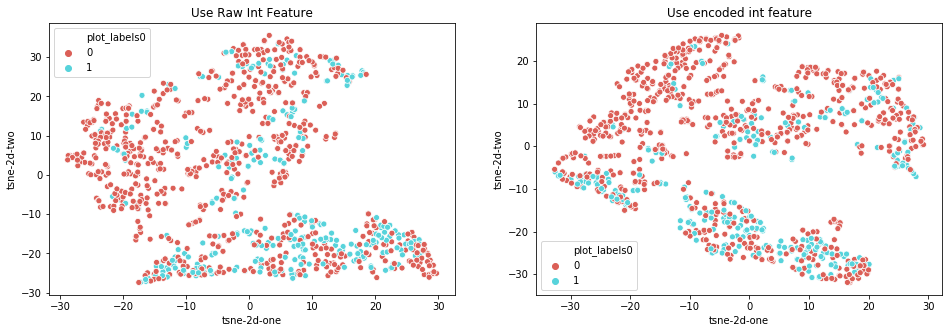

In [16]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(selected_feat_int)
fig, ax=plt.subplots(1,2,figsize=(16,5))
utilities.tsne_2d_visulization(selected_feat_int, true_label_biclass, ax=ax[0], verbose=0)
utilities.tsne_2d_visulization(hidden_feat, true_label_biclass, ax=ax[1], verbose=0)
ax[0].set_title('Use Raw Int Feature')
ax[1].set_title('Use encoded int feature')

In [37]:
# normalization
autoencoder_dims = [59,40,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25, clustering_tol=1e-3)

cl_weights = np.arange(0.1, 1, 0.1)
results = []
hidden_feats=[]

for cl_weight in cl_weights:
    dce.build_model()
    dce.model.summary()
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(selected_feat_int,clustering_loss='kld', 
                               decoder_loss='mse',
                               training_prints=False,
                               norm_feature=True, 
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    hidden_feats.append(encoder.predict(selected_feat_int))
    print('Training finished and the results are recorded')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 59)           0                                            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 59)           236         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 40)           2400        batch_normalization_10[0][0]     
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           820         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 59)           0                                            
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 59)           236         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 40)           2400        batch_normalization_14[0][0]     
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           820         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 (Dense)               (None, 40)           840         embedding_layer[0][0]            
__________

input (InputLayer)              (None, 59)           0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 59)           236         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 40)           2400        batch_normalization_18[0][0]     
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           820         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 (Dense)               (None, 40)           840         embedding_layer[0][0]            
__________________________________________________________________________________________________
clustering

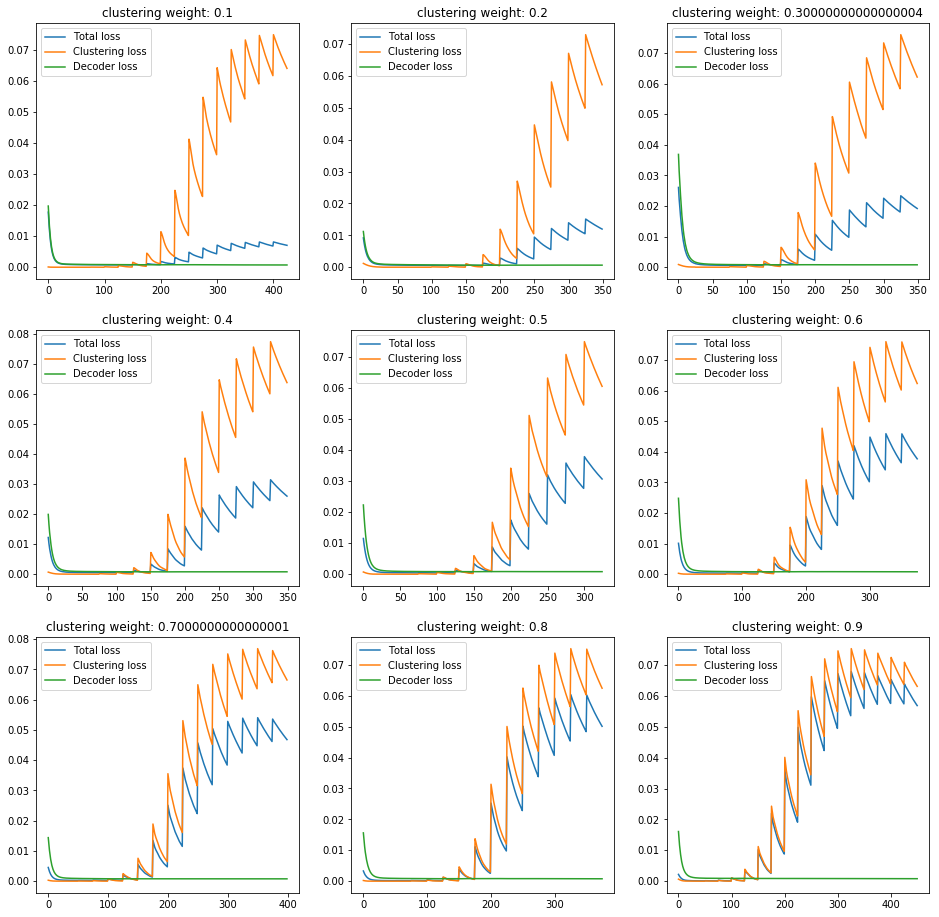

In [38]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))


In [43]:
ad_rands=[]
for r in results:
    ad_rands.append(Cluster.true_label_metrics(true_label_biclass, r[0], print_metric=True)['adjusted_rand_score'])

Metric with True label
adjusted rand score: 0.0034385108256786254 
fowlkes_mallows : 0.543931205421471
Metric with True label
adjusted rand score: -0.001151517480376231 
fowlkes_mallows : 0.542386755503876
Metric with True label
adjusted rand score: 0.055898349681564284 
fowlkes_mallows : 0.5681386586486552
Metric with True label
adjusted rand score: 0.0071839694329305 
fowlkes_mallows : 0.546224236022918
Metric with True label
adjusted rand score: -8.617768825151182e-05 
fowlkes_mallows : 0.5423869845746252
Metric with True label
adjusted rand score: 0.012963561546005285 
fowlkes_mallows : 0.5505406160395757
Metric with True label
adjusted rand score: -0.001800343737495418 
fowlkes_mallows : 0.5430883305519818
Metric with True label
adjusted rand score: -0.002287172571098908 
fowlkes_mallows : 0.5445753853270408
Metric with True label
adjusted rand score: 0.0028248500012267243 
fowlkes_mallows : 0.544217390343317


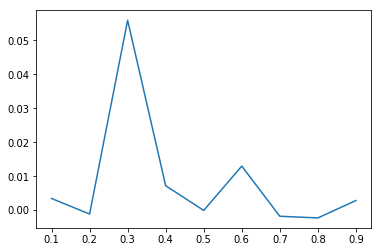

In [44]:
plt.plot(np.arange(0.1,1,0.1), ad_rands) # 0.3 as best weight

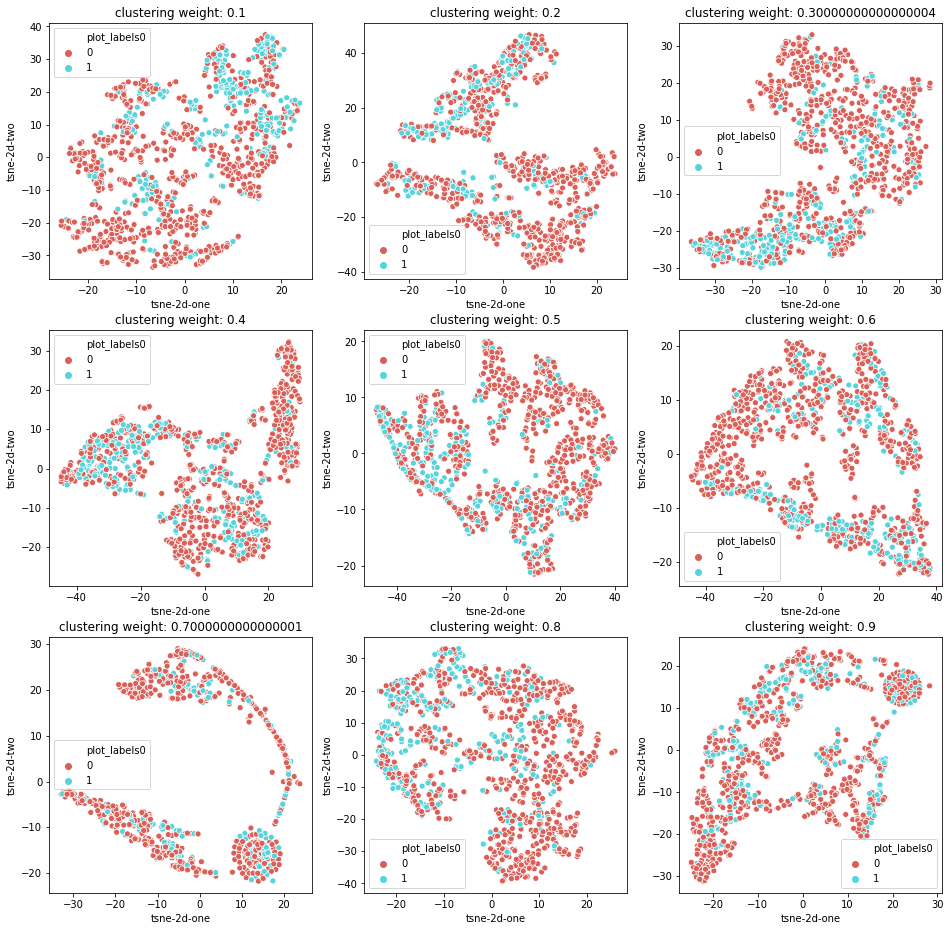

In [45]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=hidden_feats[i], 
                                   plot_labels=true_label_biclass,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

In [47]:
# no normalization
autoencoder_dims = [59,40,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25, clustering_tol=1e-3)

cl_weights = np.arange(0.1, 1, 0.1)
results_nonorm = []
hidden_feats_nonorm=[]

for cl_weight in cl_weights:
    dce.build_model(norm=False)
    dce.model.summary()
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(selected_feat_int,clustering_loss='kld', 
                               decoder_loss='mse',
                               training_prints=False,
                               norm_feature=False, 
                               clustering_loss_weight=cl_weight)
    results_nonorm.append(result_i)
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    hidden_feats_nonorm.append(encoder.predict(selected_feat_int))
    print('Training finished and the results are recorded')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 59)           0                                            
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 40)           2400        input[0][0]                      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           820         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 (Dense)               (None, 40)           840         embedding_layer[0][0]            
__________________________________________________________________________________________________
clustering

__________________________________________________________________________________________________
decoder_1 (Dense)               (None, 40)           840         embedding_layer[0][0]            
__________________________________________________________________________________________________
clustering (KMeansLayer)        (None, 2)            40          embedding_layer[0][0]            
__________________________________________________________________________________________________
decoder_output (Dense)          (None, 59)           2419        decoder_1[0][0]                  
Total params: 6,519
Trainable params: 6,519
Non-trainable params: 0
__________________________________________________________________________________________________
Start to train model with cluster weight: 0.5
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
____________________________________________________________________

Start to train model with cluster weight: 0.9
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded


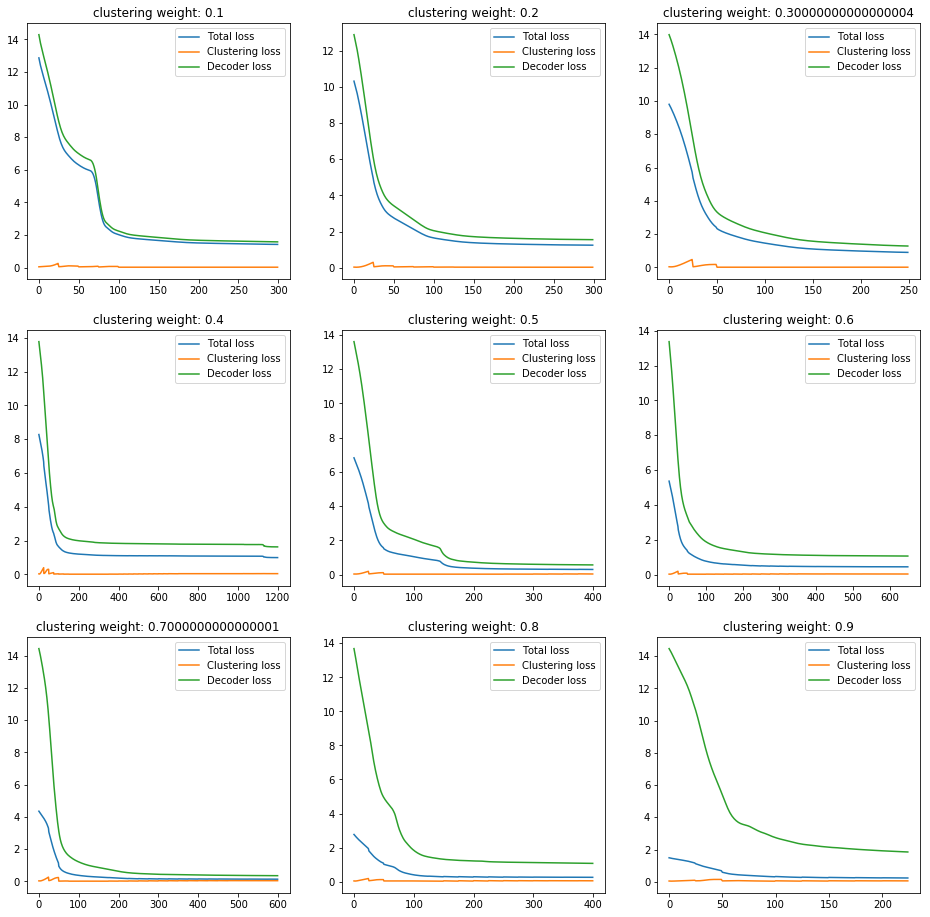

In [49]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results_nonorm[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results_nonorm[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results_nonorm[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))


In [50]:
ad_rands_nonorm=[]
for r in results_nonorm:
    ad_rands_nonorm.append(Cluster.true_label_metrics(true_label_biclass, r[0], print_metric=True)['adjusted_rand_score'])

Metric with True label
adjusted rand score: 0.00048571216029056876 
fowlkes_mallows : 0.5447282235813987
Metric with True label
adjusted rand score: 0.017717053072769176 
fowlkes_mallows : 0.5555744359128294
Metric with True label
adjusted rand score: 0.0567845372831396 
fowlkes_mallows : 0.7124726167546283
Metric with True label
adjusted rand score: 0.025768888522541528 
fowlkes_mallows : 0.5579706575012555
Metric with True label
adjusted rand score: 0.004579674307358485 
fowlkes_mallows : 0.5469827513648353
Metric with True label
adjusted rand score: 0.0004113073796750327 
fowlkes_mallows : 0.5445159892128938
Metric with True label
adjusted rand score: 0.007433801137601775 
fowlkes_mallows : 0.5464878225306886
Metric with True label
adjusted rand score: 0.0012904052378445215 
fowlkes_mallows : 0.5432998816121991
Metric with True label
adjusted rand score: -9.876595752329997e-05 
fowlkes_mallows : 0.5424004154618424


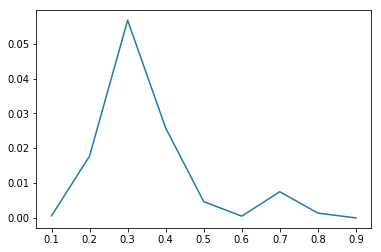

In [51]:
plt.plot(np.arange(0.1,1,0.1), ad_rands_nonorm) # 0.3 as best weight

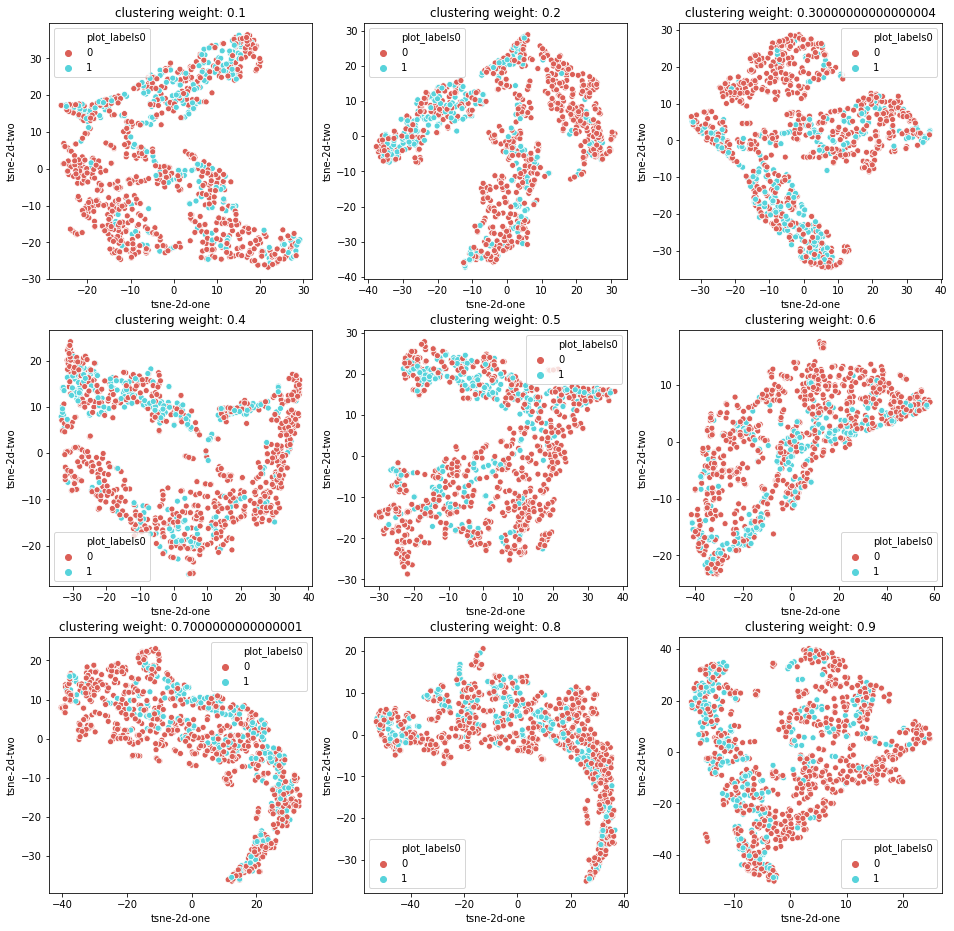

In [52]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=hidden_feats_nonorm[i], 
                                   plot_labels=true_label_biclass,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))